In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Week 1

In [2]:
inflows = pd.read_parquet('data/ucsd-inflows.pqt')
outflows = pd.read_parquet('data/ucsd-outflows.pqt')

display(inflows.head(), outflows.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [3]:
outflows.posted_date = pd.to_datetime(outflows.posted_date)

I create a subset of `outflows` that doesn't include rows where `memo == category` because these are the rows that we train our model on to predict `category`.

In [4]:
outflows_with_memo = outflows[~(outflows.memo == outflows.category)].reset_index().drop(columns='index')
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### EDA

## WEEK 2 - Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

#### Sample by consumer instead of transaction to avoid sampling bias

**From here on out, I only work with `outflows_with_memo` because that is the subset of the data we were told to work with.** This doesn't include rows where `memo == category`, and thereby includes rows that are pivotal to our prediction task.

In [6]:
def dataset_split(dataset):
    # get unique consumer ids
    ids = dataset.prism_consumer_id.unique()
    train_ids, test_ids = train_test_split(ids, test_size=0.25)

    # split customer_ids into train and test sets
    train = dataset[dataset['prism_consumer_id'].isin(train_ids)]
    test = dataset[dataset['prism_consumer_id'].isin(test_ids)]

    return train, test

In [7]:
outflows_memo_train, outflows_memo_test = dataset_split(outflows_with_memo)

In [8]:
outflows_memo_train.shape, outflows_memo_test.shape

((981725, 6), (324727, 6))

For the subset of outflows that doesn't have the category given in the memo

In [9]:
print(f'# of unique IDS: {len(outflows_with_memo.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_memo_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_memo_test.prism_consumer_id.unique())}')

# of unique IDS: 2952, # of unique train IDS: 2214, # of unique test IDS: 738


In [10]:
outflows_with_memo.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,1306452.00000,1306452.00000,1306452.00000
mean,3182.59410,53.89793,.5f
min,0.00000,0.00000,.5f
25%,1501.00000,9.00000,.5f
50%,3421.00000,19.47000,.5f
75%,4787.00000,42.58000,.5f
max,5943.00000,280171.35000,.5f
std,1801.11219,635.18547,nan


In [11]:
outflows_memo_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,981725.00000,981725.00000,981725.00000
mean,3204.65014,54.55844,.5f
min,0.00000,0.00000,.5f
25%,1522.00000,8.99000,.5f
50%,3470.00000,19.32000,.5f
75%,4787.00000,42.19000,.5f
max,5943.00000,279412.00000,.5f
std,1795.06220,654.80501,nan


In [12]:
outflows_memo_test.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,324727.00000,324727.00000,324727.00000
mean,3115.91356,51.90106,.5f
min,13.00000,0.00000,.5f
25%,1430.00000,9.18000,.5f
50%,3319.00000,19.97000,.5f
75%,4801.00000,43.65000,.5f
max,5939.00000,280171.35000,.5f
std,1817.65623,571.78783,nan


#### TODO include statistical tests to ensure distributions are similar

## WEEK 3 - Memo Cleaning

In [13]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### Memo cleaning steps:
- did more complex preprocessing first 
    - lemmatizer? (might not be good for this because it could stem words it shouldn't
    - same thing for stop words
    - remove dates (regex search mm/yy) and location addresses
    - get rid of email addresses -- TODO 
    - trans 1 @ $1.00 -- TODO
- simple preprocessing
    - lowercase 
    - remove punctuation (,-*#_')
    - remove XXXX, even amount of X's
    - remove purchase authorized on
    - remove purchase, checkcard
- should not preprocess memos that are the same category

In [14]:
memos[memos.str.contains('@')].values[:1000]

NameError: name 'memos' is not defined

In [ ]:
# looking at 
test = memos.str.replace(r'trans \d+ @ \$\d+\.\d{2}', 'testing', regex=True)
test[(test.str.contains('@'))].values[:1000]

In [ ]:
memos[(memos.str.contains('@'))].values[:1000]

In [17]:
def clean_memos(dataset):
    memos = dataset.memo
    pattern1 = r'\b\w*x{2,}\w*\b'
    pattern2 = r'\b(0[1-9]|1[0-2])(\/|-)[0-9]{2}\b'
    pattern3 = r"[,'*#_-]"

    cleaned_memos = (
        memos.str.lower()
            .str.replace(pattern1, '', regex=True)                   # removing XXXX                        
            .str.replace(pattern2, '', regex=True)                   # removing dates
            .str.replace(pattern3, '', regex=True)                   # removing unnecessary special characters
            .str.replace(r'~', '', regex=True)                       # removing ~ (can't include in character class above)
            .str.replace('purchase.* authorized on', '', regex=True) # removing common phrase
            .str.replace('checkcard', '')                            # removing common phrase
            .str.strip()                                             # removing leading and trailing characters
    )

    cleaned_memos = cleaned_memos.reset_index().drop(columns='index').squeeze()
    dataset['cleaned_memo'] = cleaned_memos

    return dataset

In [18]:
outflows_with_memo = clean_memos(outflows_with_memo)

In [19]:
memos = outflows_with_memo.memo
cleaned_memos = outflows_with_memo.cleaned_memo

In [20]:
memos.unique().__len__(), cleaned_memos.unique().__len__(), 

(528766, 307409)

In [21]:
memos_counts = memos.value_counts()
cleaned_memos_counts = cleaned_memos.value_counts()

In [22]:
memos_counts

memo
Amazon                                                                               31725
Walmart                                                                              31619
McDonald's                                                                           22670
Starbucks                                                                            12777
7-Eleven                                                                             11675
                                                                                     ...  
Doordash Kazu Sushi Bu                                                                   1
Par Gators Dockside -                                                                    1
Chilis Mandarin                                                                          1
Chilis Bay Meadows                                                                       1
POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS RD MESA AZ  Card 15 #XXXX  MCC XXXX    

In [23]:
cleaned_memos_counts

cleaned_memo
walmart                                                          32099
amazon                                                           31737
mcdonalds                                                        27598
starbucks                                                        12823
7eleven                                                          11821
                                                                 ...  
lobby bar lake charles la  card                                      1
total wine and friendswood tx  card                                  1
victoria bridal houston tx  card                                     1
liquor hu  fm  baytown tx  card                                      1
pos withdrawalwalmart   e mckellips rd mesa az  card 15   mcc        1
Name: count, Length: 307409, dtype: int64

In [3]:
plt.hist(memos_counts[memos_counts < 5])
plt.show()

NameError: name 'plt' is not defined

In [25]:
(memos_counts == 1).sum()

443287

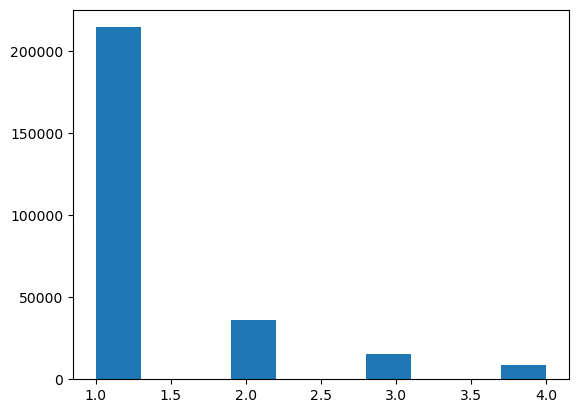

In [26]:
plt.hist(cleaned_memos_counts[cleaned_memos_counts < 5])
plt.show()

In [27]:
(cleaned_memos_counts == 1).sum()

214737

## Week 4

In [28]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh


### Creating Features

#### TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def get_tfidf_features(dataset, max_features):
    cleaned_memos = dataset.cleaned_memo
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf = vectorizer.fit_transform(cleaned_memos)
    
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
    tfidf_df.columns = 'tfidf_' + vectorizer.get_feature_names_out()
    
    return tfidf_df

#### Dates and Amounts

**Date Features**
- month of year -- charges change by month (increase in food_and_beverages in summer, general_merchandise during holidays, travel)
- day of week -- charges change by day (weekend may see more food spending, weekday for groceries)
- day of month -- beginning of month charges (rent) vs middle of month charges (utilities) vs end of month (credit card?)

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
def get_date_features(dataset):
    posted_date = dataset.posted_date
    date_features = pd.DataFrame()
    
    date_features['month'] = 'month_' + posted_date.dt.month.astype(str)
    date_features['weekday'] = 'weekday_' + posted_date.dt.weekday.astype(str)
    date_features['day_of_month'] = 'day_of_month_' + posted_date.dt.day.astype(str)

    date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    date_one_hot = date_enc.fit_transform(date_features)

    date_columns = np.concatenate([feature[1:] for feature in date_enc.categories_])
    date_one_hot_df = pd.DataFrame.sparse.from_spmatrix(date_one_hot, columns=date_columns)

    return date_one_hot_df

**Amount Features**
- is even amount (x.00)
- bin the amounts based on size
    - potentially by category as well?

In [33]:
def get_amount_features(dataset):
    amount = dataset.amount

    amount_features = pd.DataFrame()
    amount_features['is_even'] = amount.apply(lambda x: 'amount_even' if x % 1 == 0 else 'amount_odd')
    amount_features['decile_amounts'] = pd.qcut(amount, q=10, labels=['decile_0', 'decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'])

    amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    amount_one_hot = amount_enc.fit_transform(amount_features)

    amount_columns = np.concatenate([feature[1:] for feature in amount_enc.categories_])
    amount_one_hot_df = pd.DataFrame.sparse.from_spmatrix(amount_one_hot, columns=amount_columns)
    
    return amount_one_hot_df

### Putting Features Together

In [34]:
def get_features_df(dataset, tfidf_max_features):
    tfidf_df = get_tfidf_features(dataset, tfidf_max_features)
    date_df = get_date_features(dataset)
    amount_df = get_amount_features(dataset)

    features_df =  pd.concat([dataset, tfidf_df, date_df, amount_df], axis=1)
    return features_df

In [35]:
def train_test_split_features(dataset, tfidf_max_features):
    features_df = get_features_df(dataset, tfidf_max_features)
    train_df, test_df = dataset_split(features_df)
    
    X_train = train_df.iloc[:, 7:]
    y_train = train_df['category']
    X_test = test_df.iloc[:, 7:]
    y_test = test_df['category']

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    return X_train, y_train, X_test, y_test

In [36]:
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=50)

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((961744, 107), (961744,), (344708, 107), (344708,))

### Training Models

In [44]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Logistic Regression

In [39]:
def fit_model(X_train, y_train, model_type):
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train, y_train)
    elif model_type == 'xgboost':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # hyperparameters to consider: n_estimators, max_depth, learning_rate
        model = XGBClassifier(objective='multi:softmax')
        model.fit(X_train, y_train_encoded)

        return model, le

    return model

In [40]:
def predict(X, y, model, le=None):
    if isinstance(model, LogisticRegression):
        preds = model.predict(X)
    elif isinstance(model, XGBClassifier):
        preds_encoded = model.predict(X)
        preds = le.inverse_transform(preds_encoded)
    
    print(f"Accuracy: {(preds == y).mean():.3f}")
    
    return preds

In [41]:
def fit_and_predict(X_train, y_train, X_test, y_test, model_type):
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train, y_train) 
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        
    elif model_type == 'xgboost':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # hyperparameters to consider: n_estimators, max_depth, learning_rate
        model = XGBClassifier(objective='multi:softmax')
        model.fit(X_train, y_train_encoded)

        preds_train_encoded = model.predict(X_train)
        preds_test_encoded = model.predict(X_test)
        
        preds_train = le.inverse_transform(preds_train_encoded)
        preds_test = le.inverse_transform(preds_test_encoded)

    print(f"Train accuracy: {(preds_train == y_train).mean()}, Test accuracy: {(preds_test == y_test).mean()}")
    
    return model, preds_train, preds_test

In [78]:
# for i in range(len(coef_df)):
#     display(coef_df.iloc[i].abs().sort_values(ascending=False).iloc[:10])

**Accuracy by category**

In [43]:
def make_confusion_matrices(y_train, preds_train, y_test, preds_test):
    
    def make_conf_matrix(y, preds):
        conf_matrix = confusion_matrix(y, preds, labels=y.unique(), normalize='pred')
        classes = y.value_counts().sort_values(ascending=False).index
        conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
        return conf_matrix_df

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 13))
    conf_matrix_train = make_conf_matrix(y_train, preds_train)
    sns.heatmap(conf_matrix_train, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title('Train Precision')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    
    conf_matrix_test = make_conf_matrix(y_test, preds_test)
    sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax2)
    ax2.set_title('Test Precision')
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    plt.tight_layout(rect=[0.0, 0.0, 1, 1])
    plt.subplots_adjust(wspace=0.5, hspace=0.55)
    plt.show()

In [145]:
# tfidf generation taking longer than log reg model fitting
# 3000 tfidf taking close to 2 min
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=5000)

In [52]:
log_reg = fit_model(X_train, y_train, 'log_reg')

In [56]:
predict(X_train, y_train, log_reg)

Accuracy: 0.711


array(['FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES', 'FOOD_AND_BEVERAGES',
       ..., 'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE',
       'FOOD_AND_BEVERAGES'], dtype=object)

In [ ]:
bst, le = fit_model(X_train, y_train, 'xgboost')

In [ ]:
predict(X_train, y_train, bst, le)

In [146]:
%%time
# 500 tfidf - 61 seconds - Train accuracy: 0.873, Test accuracy: 0.863
# 750 tfidf - 62 seconds - Train accuracy: 0.895, Test accuracy: 0.889
# 1000 tfidf - 63 seconds - Train accuracy: 0.911, Test accuracy: 0.906
# 2000 tfidf - 66 seconds - Train accuracy: 0.938, Test accuracy: 0.927
# 3000 tfidf - 77 seconds - Train accuracy: 0.952, Test accuracy: 0.939
# 5000 tfidf - 68 seconds - Train accuracy: 0.964, Test accuracy: 0.941
log_reg, preds_train, preds_test = fit_and_predict(X_train, y_train, X_test, y_test, model_type='log_reg')

Train accuracy: 0.9643085815237094, Test accuracy: 0.9413808806315461
CPU times: user 2.96 s, sys: 682 ms, total: 3.65 s
Wall time: 1min 5s


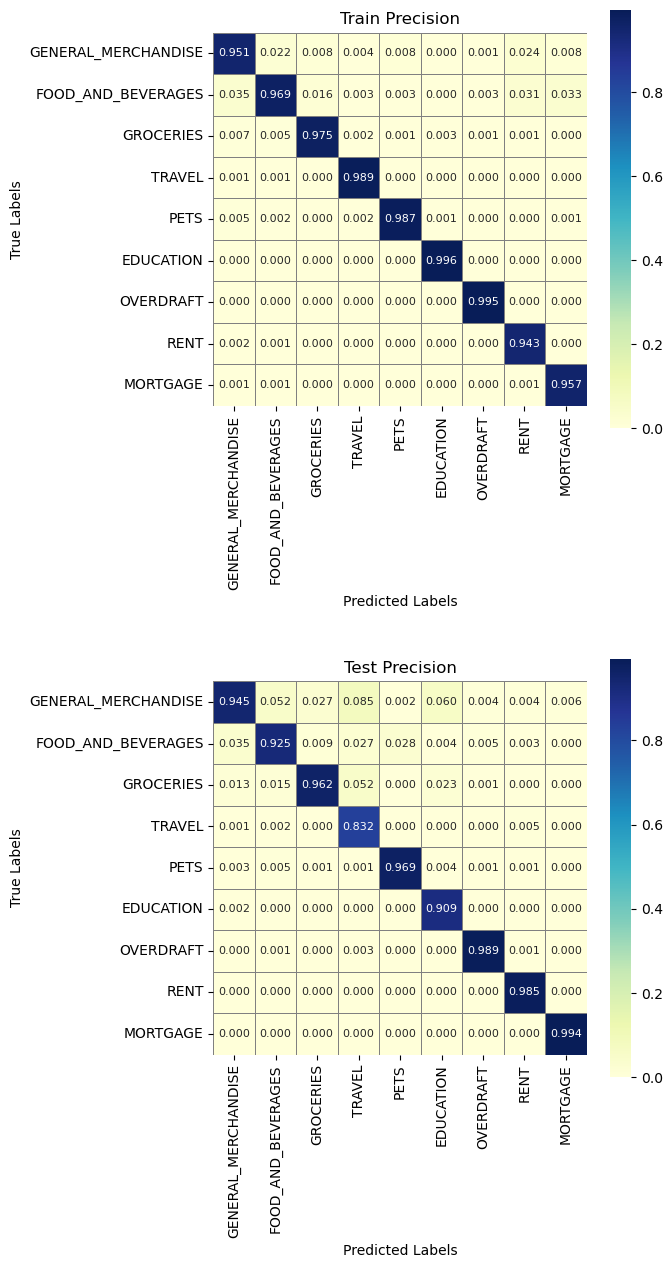

In [147]:
make_confusion_matrices(y_train, preds_train, y_test, preds_test)

#### Gradient Boosting (XGBoost)

In [74]:
# !pip install xgboost

In [78]:
# 30ish seconds
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Train accuracy: 0.7295791756517578, Test accuracy: 0.7173482156721258


In [80]:
# 'Train accuracy: 0.7301464661398314, Test accuracy: 0.7111407249466951' ------ basic xgboost w/ 50 features

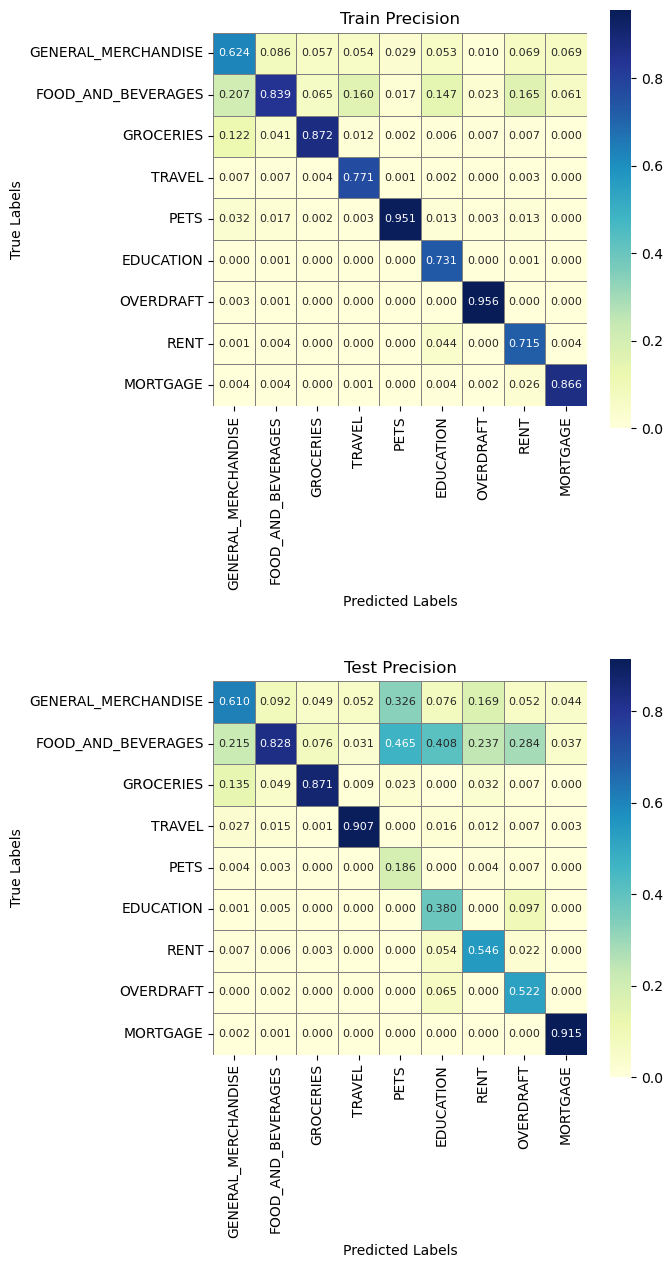

In [79]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

In [108]:
# testing how many tfidf features xgboost can handle
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=750)

In [109]:
# 200 tfidf - 53 seconds - Train accuracy: 0.817, Test accuracy: 0.800
# 400 tfidf - 87 seconds - Train accuracy: 0.866, Test accuracy: 0.848
# 500 tfidf - 101 seconds - Train accuracy: 0.876, Test accuracy: 0.863
# 750 tfidf - 376 seconds - Train accuracy: 0.8941, Test accuracy: 0.882
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/home/drmathew/.local/lib/python3.11/site-packages/xgboost/data.py:575: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Train accuracy: 0.8941159906773128, Test accuracy: 0.8823433578856017


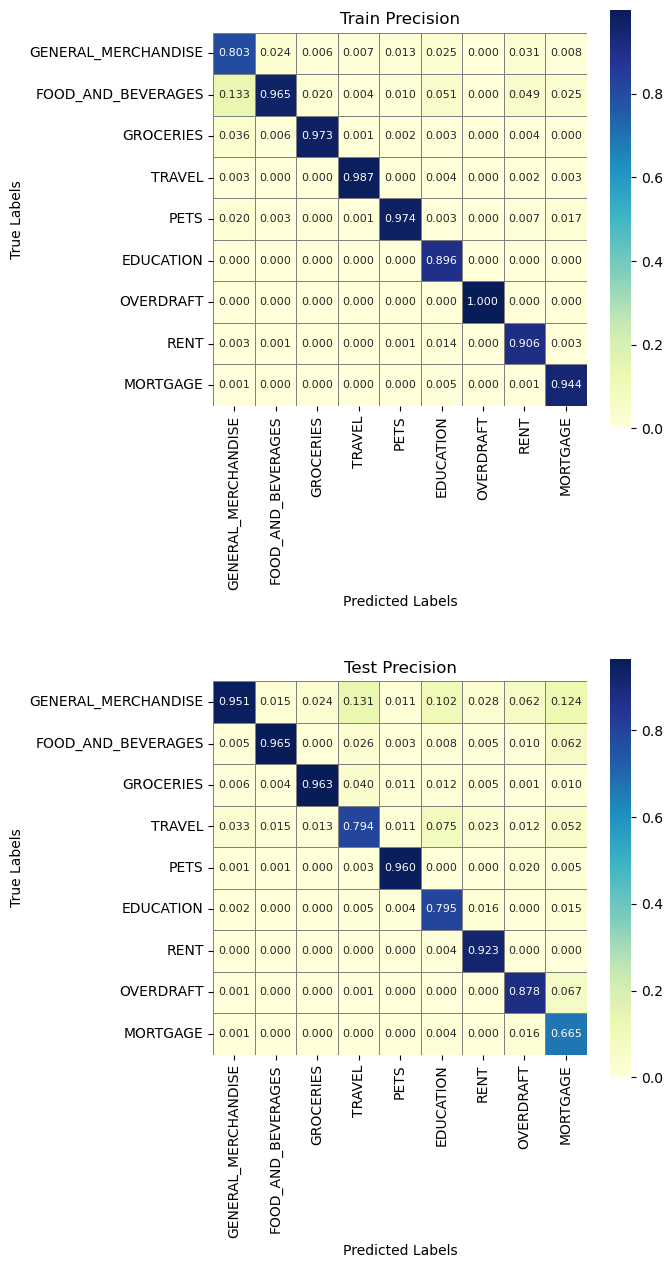

In [110]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

## Full Pipeline

In [ ]:
def pipeline():
    # cleaned_dataset = put dataset through cleaning()
    # allFunctions(cleaned_dataset)